In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from gmdh import Combi, Mia
from gplearn.genetic import SymbolicRegressor
import warnings

warnings.filterwarnings("ignore")

1) Загрузка и агрегация временного ряда...
 → Размер после агрегации: (117549, 1)


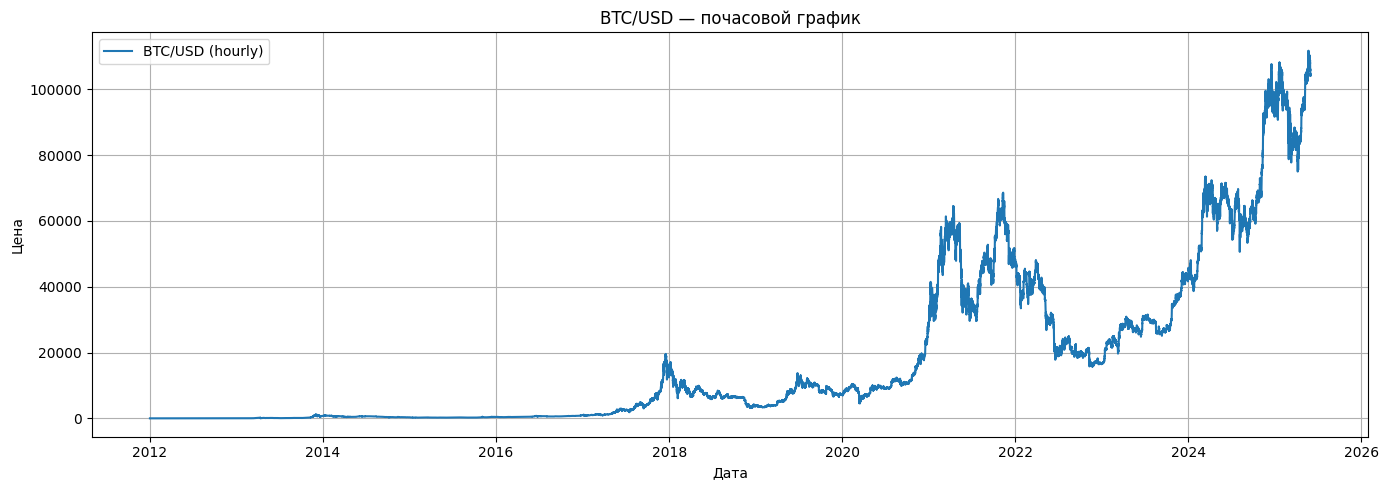

In [2]:
# 1. Загрузка и агрегация
print("1) Загрузка и агрегация временного ряда...")
df = pd.read_csv('dataset/btcusd_1-min_data.csv', usecols=['Timestamp', 'Close'])
df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Datetime', inplace=True)
df = df[['Close']]
df = df.resample('1H').mean().dropna()

print(" → Размер после агрегации:", df.shape)

# Визуализация исходного ряда
plt.figure(figsize=(14, 5))
plt.plot(df['Close'], label='BTC/USD (hourly)')
plt.title('BTC/USD — почасовой график')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


2) Разделение на обучающую и тестовую выборку...


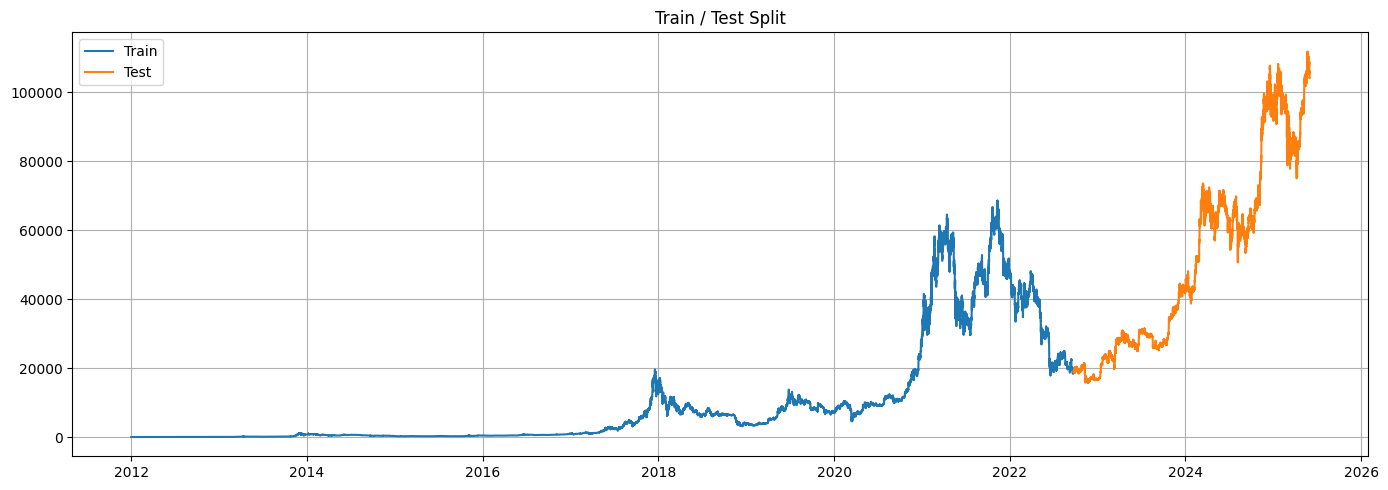

In [3]:
# 2. Train/Test Split
print("\n2) Разделение на обучающую и тестовую выборку...")
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

plt.figure(figsize=(14, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('Train / Test Split')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

train_values = train['Close'].values
test_values = test['Close'].values

In [4]:
# 3. ARIMA
print("\n3) Прогноз с помощью ARIMA (фиксированные параметры)...")

order = (4, 1, 5)
model_arima = ARIMA(train_values, order=order)
model_fit = model_arima.fit()

forecast_arima = model_fit.forecast(steps=len(test_values))
mae_arima = mean_absolute_error(test_values, forecast_arima)
r2_arima = r2_score(test_values, forecast_arima)
print(f" → ARIMA (manual): MAE = {mae_arima:.2f}, R² = {r2_arima:.4f}")


3) Прогноз с помощью ARIMA (фиксированные параметры)...
 → ARIMA (manual): MAE = 32887.54, R² = -1.3944


In [5]:
# 4. Символьная регрессия
print("\n4) Прогноз с помощью символьной регрессии...")
window = 10

def create_lag_features(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i - window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X_total, y_total = create_lag_features(df['Close'].values, window)
X_train_sr, X_test_sr = X_total[:train_size - window], X_total[train_size - window:]
y_train_sr, y_test_sr = y_total[:train_size - window], y_total[train_size - window:]

model_sr = SymbolicRegressor(
    population_size=200,
    generations=10,
    stopping_criteria=0.01,
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    random_state=42,
    n_jobs=1
)
model_sr.fit(X_train_sr, y_train_sr)
forecast_sr = model_sr.predict(X_test_sr)
mae_sr = mean_absolute_error(y_test_sr, forecast_sr)
r2_sr = r2_score(y_test_sr, forecast_sr)
print(f" → Symbolic Regression: MAE = {mae_sr:.2f}, R² = {r2_sr:.4f}")


4) Прогноз с помощью символьной регрессии...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    24.28      5.91314e+35        7          42.3099           42.181     15.92s
   1    11.04      7.07225e+15        7          42.0908          44.1617     10.97s
   2     6.78      2.41067e+07        5          41.9533          45.3944      8.34s
   3     6.00      5.30102e+06        1          42.0631          44.4005      7.00s
   4     4.94      3.50782e+15        7          42.0716           44.327      5.73s
   5     3.07       3.1309e+08        1          41.8566          46.2591      4.02s
   6     2.19      4.82302e+06        1          41.8914          45.9454      2.94s
   7     1.58      6.41222e+06        1          41.9974          44.9918      1.85s
   8     1.50      8.10157e+0

In [6]:
# 5. GMDH
print("\n5) Прогноз с помощью GMDH...")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_total)
X_train_gmdh, X_test_gmdh = X_scaled[:train_size - window], X_scaled[train_size - window:]
y_train_gmdh, y_test_gmdh = y_total[:train_size - window], y_total[train_size - window:]

# Combi
forecast_combi = None
try:
    gmdh_combi = Combi()
    gmdh_combi.fit(X_train_gmdh, y_train_gmdh)
    forecast_combi = gmdh_combi.predict(X_test_gmdh)
    mae_combi = mean_absolute_error(y_test_gmdh, forecast_combi)
    r2_combi = r2_score(y_test_gmdh, forecast_combi)
    print(f" → GMDH Combi: MAE = {mae_combi:.2f}, R² = {r2_combi:.4f}")
except Exception as e:
    print("Ошибка Combi:", e)

# Mia
forecast_mia = None
try:
    gmdh_mia = Mia()
    gmdh_mia.fit(X_train_gmdh, y_train_gmdh)
    forecast_mia = gmdh_mia.predict(X_test_gmdh)
    mae_mia = mean_absolute_error(y_test_gmdh, forecast_mia)
    r2_mia = r2_score(y_test_gmdh, forecast_mia)
    print(f" → GMDH Mia: MAE = {mae_mia:.2f}, R² = {r2_mia:.4f}")
except Exception as e:
    print("Ошибка Mia:", e)


5) Прогноз с помощью GMDH...
 → GMDH Combi: MAE = 136.83, R² = 0.9999
 → GMDH Mia: MAE = 289.47, R² = 0.9996



6) Визуализация прогнозов для каждой модели...


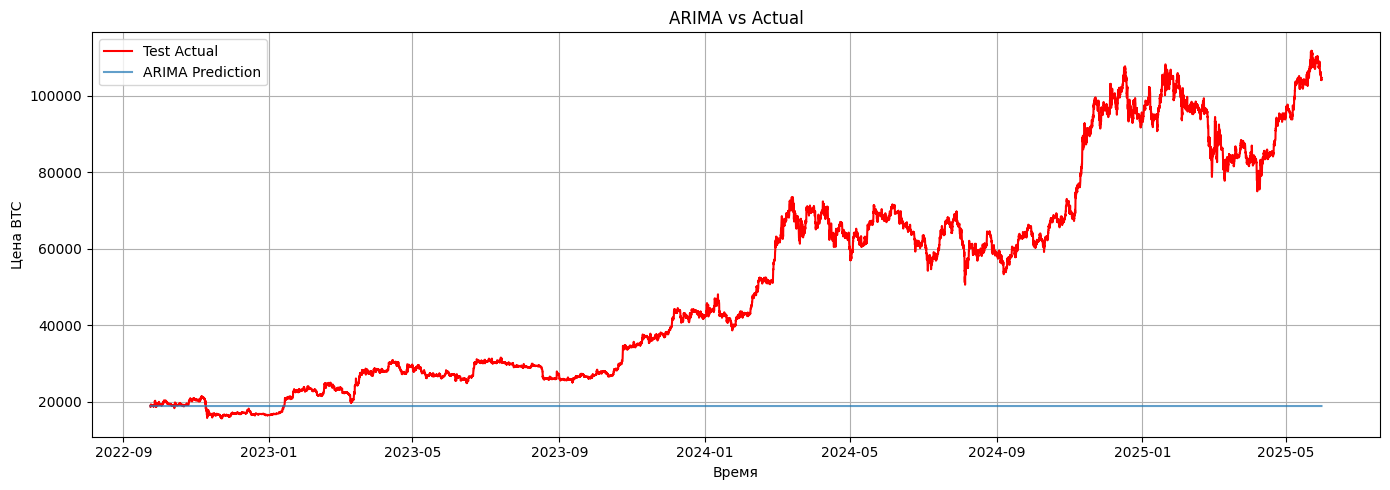

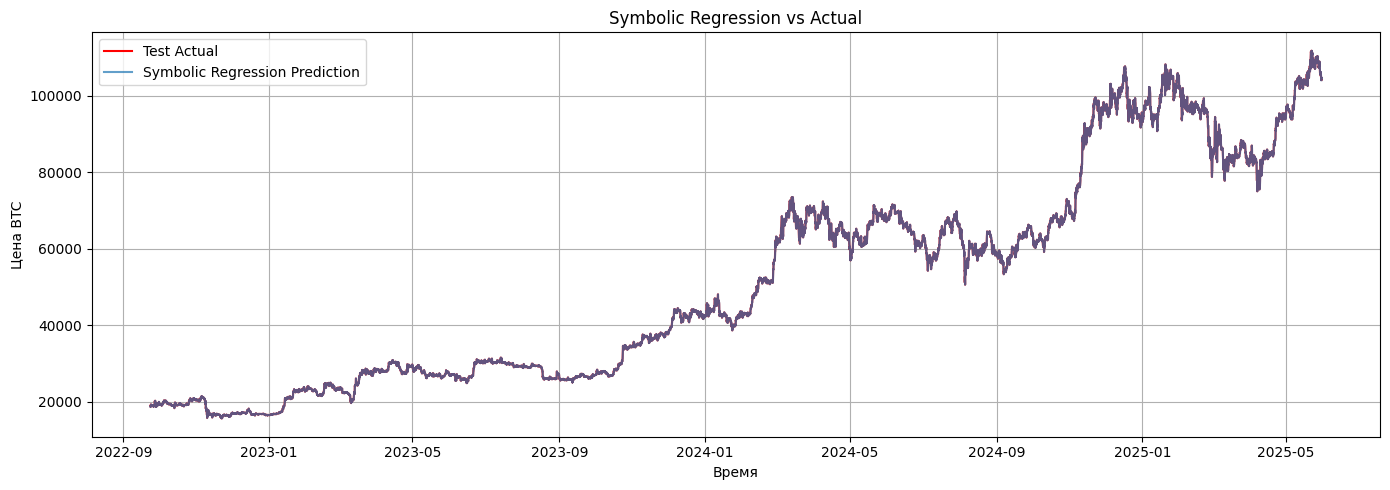

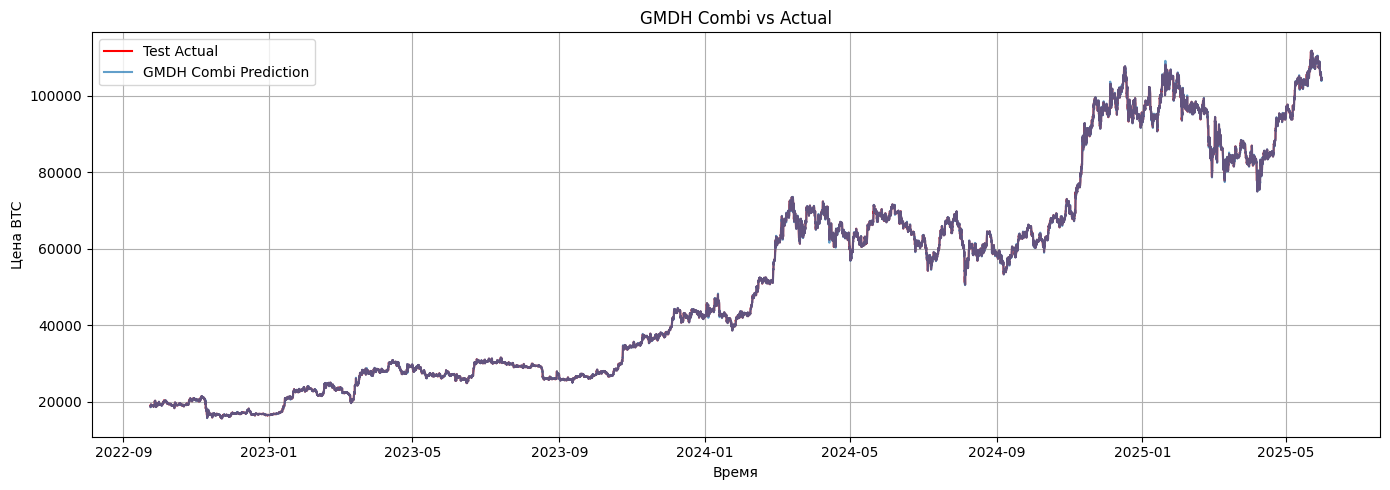

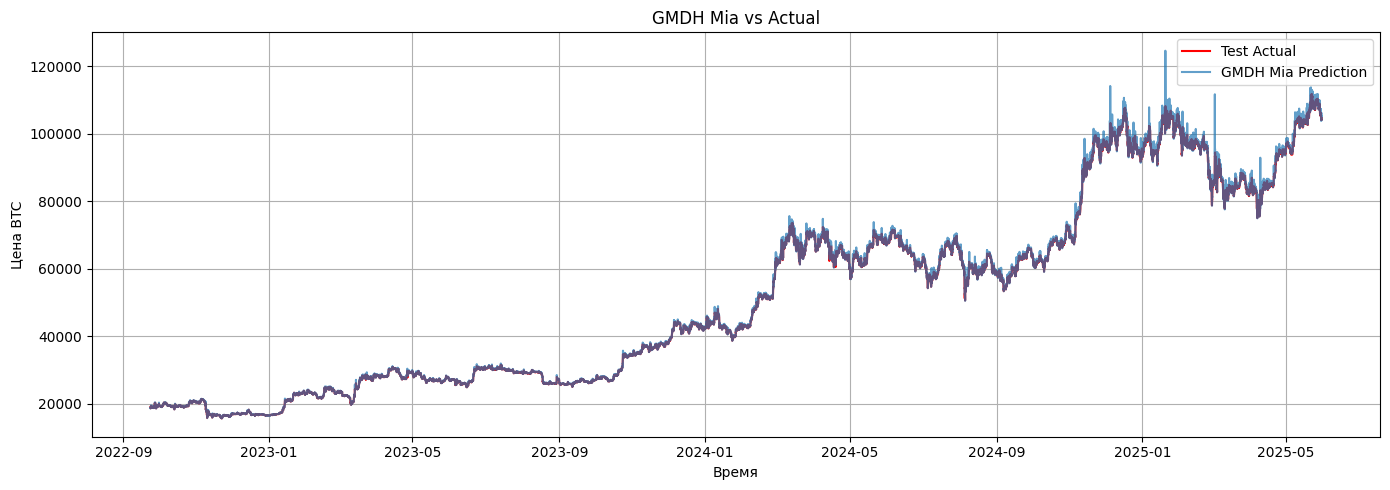

In [7]:
# 6. Визуализация для каждой модели отдельно
print("\n6) Визуализация прогнозов для каждой модели...")

forecast_index_full = test.index
forecast_index_lag = test.index[:len(y_test_sr)]

def plot_model_results(actual, predicted, index, model_name):
    plt.figure(figsize=(14, 5))
    plt.plot(index, actual, label='Test Actual', color='red')
    plt.plot(index, predicted, label=f'{model_name} Prediction', alpha=0.7)
    plt.title(f'{model_name} vs Actual')
    plt.xlabel('Время')
    plt.ylabel('Цена BTC')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# ARIMA
plot_model_results(test_values, forecast_arima, forecast_index_full, 'ARIMA')

# Symbolic Regression
plot_model_results(y_test_sr, forecast_sr, forecast_index_lag, 'Symbolic Regression')

# GMDH Combi
if forecast_combi is not None:
    plot_model_results(y_test_gmdh, forecast_combi, forecast_index_lag, 'GMDH Combi')

# GMDH Mia
if forecast_mia is not None:
    plot_model_results(y_test_gmdh, forecast_mia, forecast_index_lag, 'GMDH Mia')

In [8]:
# 7. Таблица метрик
print("\n7) Метрики качества моделей:")
results = pd.DataFrame([
    {'Model': 'ARIMA', 'MAE': mae_arima, 'R2': r2_arima},
    {'Model': 'Symbolic Regression', 'MAE': mae_sr, 'R2': r2_sr},
    {'Model': 'GMDH Combi', 'MAE': mae_combi if forecast_combi is not None else None,
     'R2': r2_combi if forecast_combi is not None else None},
    {'Model': 'GMDH Mia', 'MAE': mae_mia if forecast_mia is not None else None,
     'R2': r2_mia if forecast_mia is not None else None}
])

print(results.round(4))


7) Метрики качества моделей:
                 Model         MAE      R2
0                ARIMA  32887.5417 -1.3944
1  Symbolic Regression    139.9119  0.9999
2           GMDH Combi    136.8252  0.9999
3             GMDH Mia    289.4740  0.9996
